Задача которую я буду решать -  классификация еды по картинке

In [1]:
# !pip install --upgrade torch torchvision torchtext torchaudio transformers sentencepiece
import torch
import pandas as pd
import numpy as np
# from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
# !pip install datasets
# from datasets import load_dataset
# from sklearn.datasets import load_files
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
# from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
from torch.utils.data import random_split,DataLoader
from tqdm.notebook import tqdm
# from .autonotebook import tqdm

In [2]:
!pwd
picture_height = 256
transformation = transforms.Compose([
    ToTensor(),transforms.Resize((picture_height, picture_height),antialias=False),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),transforms.CenterCrop(224)
])

/kaggle/working


In [3]:
dataset = ImageFolder("/kaggle/input/food41/images",transform = transformation)
print(dataset)
train_data, valid_data, test_data = random_split(dataset, (70000, 5000, 26000))

Dataset ImageFolder
    Number of datapoints: 101000
    Root location: /kaggle/input/food41/images
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=False)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               CenterCrop(size=(224, 224))
           )


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)


In [6]:
print(train_loader)
dataiter = iter(train_loader)

In [7]:
imgs, labels = next(dataiter)

In [8]:
def show(imgs, labels):
  f, axes = plt.subplots(1, 8, figsize=(30, 30))
  for i, axis in enumerate(axes):
    axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
    axes[i].set_title(labels[i].numpy())
  plt.show()

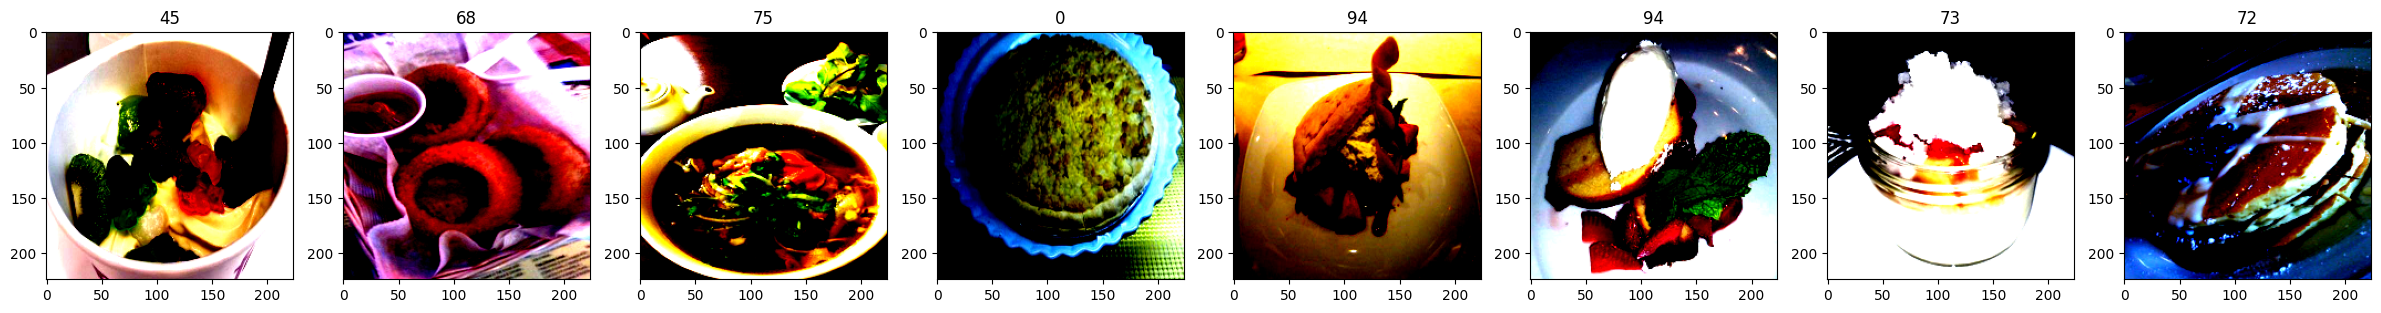

In [9]:
show(imgs, labels)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class ToVect(nn.Module):
  def forward(self, img):
    return img.view(img.size(0), -1)

Для обучения выбрал модель resnet предобученную на датасете imagenet с двумя дополнительными линейными слоями.

In [12]:
from torchvision import models
resnet18 = models.resnet34(weights='IMAGENET1K_V1')
resnet18.to(device)
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet18 = resnet18
    self.fc1 = nn.Linear(1000,4096)
    self.fc3 = nn.Linear(4096, 101)
    self.dropout = nn.Dropout(0.1)
  def forward(self, x):
    x = self.resnet18(x)
    x = F.tanh(self.fc1(x))
    x = F.softmax(self.fc3(x),dim = 1)
    return x

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 149MB/s] 


In [13]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.4 MB/s eta 0:00:00


In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
def train_one_epoch(model,epoch_index, tb_writer,optimizer):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.to(device))

        loss = loss_fn(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [15]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
def train(model, EPOCHS=13,l_r=0.0001):
  epoch_number = 0
  for epoch in range(EPOCHS):
      best_vloss = 1_000_000.
      print('EPOCH {}:'.format(epoch_number + 1))
      optimizer = torch.optim.Adam(model.parameters(), lr=l_r)
      model.train(True)
      avg_loss = train_one_epoch(model,epoch_number, writer,optimizer)


      running_vloss = 0.0
      model.eval()

      with torch.no_grad():
          for i, vdata in enumerate(valid_loader):
              vinputs, vlabels = vdata
              voutputs = model(vinputs.to(device))
              vloss = loss_fn(voutputs.to(device), vlabels.to(device))
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()

      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          model_path = 'model_{}_{}'.format(timestamp, epoch_number)
          torch.save(model.state_dict(), model_path)

      epoch_number += 1
  return model

2024-08-02 17:14:43.214130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 17:14:43.214231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 17:14:43.338633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
net = CNN().to(device)

In [17]:
# !conda install -c conda-forge ipywidgets
!jupyter nbextension enable --py widgetsnbextension
net = train(net)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
EPOCH 1:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 45.208174753189084
  batch 200 loss: 44.36087989807129
  batch 300 loss: 43.85061602592468
  batch 400 loss: 43.65717287063599
  batch 500 loss: 43.32806634902954
  batch 600 loss: 43.10980410575867
  batch 700 loss: 42.917817163467404
  batch 800 loss: 42.88135762214661
  batch 900 loss: 42.74552531242371
  batch 1000 loss: 42.72981486320496
LOSS train 42.72981486320496 valid 4.2615838050842285
EPOCH 2:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 42.29879512786865
  batch 200 loss: 42.313428688049314
  batch 300 loss: 42.13809614181518
  batch 400 loss: 42.05101838111877
  batch 500 loss: 41.77336783409119
  batch 600 loss: 41.53529052734375
  batch 700 loss: 41.41193013191223
  batch 800 loss: 41.394220209121706
  batch 900 loss: 41.23839147090912
  batch 1000 loss: 41.21192367076874
LOSS train 41.21192367076874 valid 4.10693883895874
EPOCH 3:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 40.651327633857726
  batch 200 loss: 40.68312492370605
  batch 300 loss: 40.488432550430296
  batch 400 loss: 40.67630724906921
  batch 500 loss: 40.67903466224671
  batch 600 loss: 40.46132094860077
  batch 700 loss: 40.46625013351441
  batch 800 loss: 40.36428020000458
  batch 900 loss: 40.44154849052429
  batch 1000 loss: 40.24285469055176
LOSS train 40.24285469055176 valid 4.051924228668213
EPOCH 4:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 39.92737095355987
  batch 200 loss: 39.885662984848025
  batch 300 loss: 39.99144699573517
  batch 400 loss: 40.005607676506045
  batch 500 loss: 39.99833874702453
  batch 600 loss: 39.91744205951691
  batch 700 loss: 39.90806868076324
  batch 800 loss: 39.817966556549074
  batch 900 loss: 39.963649249076845
  batch 1000 loss: 39.89206314086914
LOSS train 39.89206314086914 valid 4.009573459625244
EPOCH 5:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 39.51957898139953
  batch 200 loss: 39.643077397346495
  batch 300 loss: 39.54992227554321
  batch 400 loss: 39.591325354576114
  batch 500 loss: 39.71555693149567
  batch 600 loss: 39.691619992256165
  batch 700 loss: 39.623808932304385
  batch 800 loss: 39.64116990566254
  batch 900 loss: 39.66557903289795
  batch 1000 loss: 39.67194130420685
LOSS train 39.67194130420685 valid 4.004062175750732
EPOCH 6:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 39.392564702033994
  batch 200 loss: 39.309006977081296
  batch 300 loss: 39.289932703971864
  batch 400 loss: 39.318364763259886
  batch 500 loss: 39.302499532699585
  batch 600 loss: 39.37318375110626
  batch 700 loss: 39.3359237909317
  batch 800 loss: 39.243387651443484
  batch 900 loss: 39.31223180294037
  batch 1000 loss: 39.400968837738034
LOSS train 39.400968837738034 valid 3.9911131858825684
EPOCH 7:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 39.08079817295074
  batch 200 loss: 39.05523507595062
  batch 300 loss: 39.10262045860291
  batch 400 loss: 39.19292559623718
  batch 500 loss: 39.0774382352829
  batch 600 loss: 39.03268392086029
  batch 700 loss: 39.114612746238706
  batch 800 loss: 39.161855292320254
  batch 900 loss: 39.19968483448029
  batch 1000 loss: 39.345174527168275
LOSS train 39.345174527168275 valid 3.9870879650115967
EPOCH 8:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 38.9058051109314
  batch 200 loss: 38.93217325210571
  batch 300 loss: 38.89670286178589
  batch 400 loss: 38.93499908447266
  batch 500 loss: 38.97116568088531
  batch 600 loss: 38.880508470535275
  batch 700 loss: 39.0924325466156
  batch 800 loss: 39.017100763320926
  batch 900 loss: 39.03427345752716
  batch 1000 loss: 39.0020318031311
LOSS train 39.0020318031311 valid 3.978350877761841
EPOCH 9:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 38.75619783401489
  batch 200 loss: 38.782910513877866
  batch 300 loss: 38.796537446975705
  batch 400 loss: 38.76416368484497
  batch 500 loss: 38.90347578525543
  batch 600 loss: 38.858345532417296
  batch 700 loss: 38.73581869602204
  batch 800 loss: 38.889771294593814
  batch 900 loss: 38.941400456428525
  batch 1000 loss: 38.84176456928253
LOSS train 38.84176456928253 valid 3.9902782440185547
EPOCH 10:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 38.771499562263486
  batch 200 loss: 38.74145841598511
  batch 300 loss: 38.71807315349579
  batch 400 loss: 38.63087937831879
  batch 500 loss: 38.650290274620055
  batch 600 loss: 38.68899214267731
  batch 700 loss: 38.7720104932785
  batch 800 loss: 38.76707665920257
  batch 900 loss: 38.76288313865662
  batch 1000 loss: 38.70087027549744
LOSS train 38.70087027549744 valid 3.9759178161621094
EPOCH 11:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 38.598523020744324
  batch 200 loss: 38.60094096660614
  batch 300 loss: 38.63328840732574
  batch 400 loss: 38.54198658466339
  batch 500 loss: 38.642903852462766
  batch 600 loss: 38.59047656059265
  batch 700 loss: 38.55036416053772
  batch 800 loss: 38.688782954216
  batch 900 loss: 38.71686420440674
  batch 1000 loss: 38.61525902748108
LOSS train 38.61525902748108 valid 3.975524663925171
EPOCH 12:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 38.44716086387634
  batch 200 loss: 38.450285172462465
  batch 300 loss: 38.518652296066286
  batch 400 loss: 38.582952404022215
  batch 500 loss: 38.561253333091734
  batch 600 loss: 38.64539277553558
  batch 700 loss: 38.526163053512576
  batch 800 loss: 38.42036907672882
  batch 900 loss: 38.57508955001831
  batch 1000 loss: 38.57207179069519
LOSS train 38.57207179069519 valid 3.966306447982788
EPOCH 13:


  0%|          | 0/1094 [00:00<?, ?it/s]

  batch 100 loss: 38.379630994796756
  batch 200 loss: 38.37227864265442
  batch 300 loss: 38.411591744422914
  batch 400 loss: 38.47262547016144
  batch 500 loss: 38.36945743560791
  batch 600 loss: 38.45514533519745
  batch 700 loss: 38.5037828207016
  batch 800 loss: 38.485635900497435
  batch 900 loss: 38.45375726222992
  batch 1000 loss: 38.4122552394867
LOSS train 38.4122552394867 valid 3.9717061519622803


In [18]:
# print(net)
net.eval()
valid_dataiter = iter(valid_loader)
img, labes = next(valid_dataiter)
x = sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
counter = 0
for img,labes in valid_loader:
  counter+=1
  x+=sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
print(f"accuracy on validation dataset",(x/(counter+1)).item())
train_iter = iter(train_loader)
img, labes = next(train_iter)
x = sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
counter = 0
for img,labes in train_loader:
  counter+=1
  x+=sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
print(f"accuracy on train dataset",(x/(counter+1)).item())

test_iter = iter(test_loader)
img, labes = next(test_iter)
x = sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
counter = 0
for img,labes in test_loader:
  counter+=1
  x+=sum(torch.eq(labes.to(device), torch.argmax(net.forward(img.to(device)).detach(), axis=1)))/batch_size
print(f"accuracy on test dataset",(x/(counter+1)).item())


CNN(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [19]:
import pandas as pd
df = pd.read_table("/kaggle/input/food41/meta/meta/classes.txt",sep = ' ',header=None,names = ["food"])
print(df)

               food
0         apple_pie
1    baby_back_ribs
2           baklava
3    beef_carpaccio
4      beef_tartare
..              ...
96            tacos
97         takoyaki
98         tiramisu
99     tuna_tartare
100         waffles

[101 rows x 1 columns]


In [20]:
right_answers = np.array([0]*101)
total_pred = np.array([0]*101)
with torch.no_grad():
    for img,labes in test_loader:
        prediction = torch.argmax(net.forward(img.to(device)).detach(), axis=1).data
        labes = labes.data
        for i in range(len(prediction)):
            if prediction[i]==labes[i]:
                right_answers[prediction[i]] +=1
            total_pred[labes[i]] += 1
df["prediction accuracy"]=(right_answers/total_pred)


In [21]:
print(df)

               food  prediction accuracy
0         apple_pie             0.271318
1    baby_back_ribs             0.579167
2           baklava             0.764957
3    beef_carpaccio             0.644628
4      beef_tartare             0.481481
..              ...                  ...
96            tacos             0.601504
97         takoyaki             0.773438
98         tiramisu             0.641509
99     tuna_tartare             0.549242
100         waffles             0.667939

[101 rows x 2 columns]


Здесь можно наглядно увидеть вероятность правильного ответа среди первых 10 блюд

<Axes: ylabel='food'>

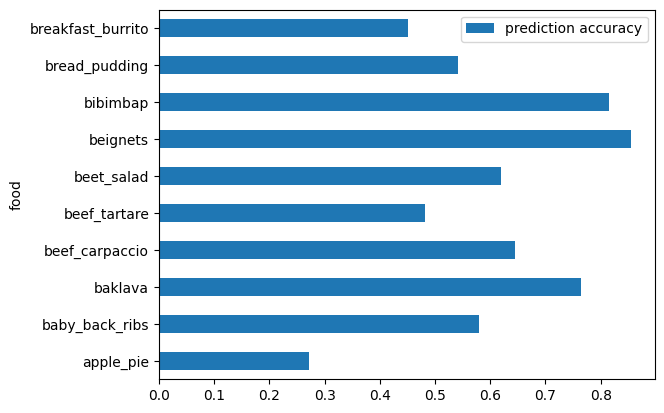

In [22]:
df[:10].plot.barh("food","prediction accuracy")

Как можно заметить нейросеть достаточно хорошо распознает некоторые блюда,например бенье,но на некоторых блюдах не хватает точности распознования. Скорее всего если бы я использовал модель EfficientNet,я бы получил лучшую точность процентов на 10,но обучение бы заняло еще несколько часов